In [1]:
import copy
import json
import torch
import warnings
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.distributions as D
import torch.nn.functional as F

from pathlib import Path
from tqdm.auto import tqdm
from torchvision import transforms
from sklearn.manifold import TSNE
# from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

warnings.filterwarnings('ignore')


ModuleNotFoundError: No module named 'torch'

In [2]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [3]:
set_seed(2024)

Random seed 2024 has been set.


In [4]:
OUTPUTS_DIR = Path('/glb/data/ptxd_dash/nlasqh/PhD_GuidedDiff/BoN/outputs')

if not Path.exists(Path(OUTPUTS_DIR)):
    Path.mkdir(Path(OUTPUTS_DIR), exist_ok=True, parents=True)

if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

In [5]:
DEVICE

'cuda'

In [6]:
OUTPUTS_DIR

PosixPath('/glb/data/ptxd_dash/nlasqh/PhD_GuidedDiff/BoN/outputs')

In [ ]:
with open(OUTPUTS_DIR.joinpath('scorers/perf_updated_clip_v2.json'),'r') as fp:
    results_code = json.load(fp)

with open(OUTPUTS_DIR.joinpath('scorers/perf_updated.json'),'r') as fp:
    results_uncond = json.load(fp)

with open(OUTPUTS_DIR.joinpath('scorers/perf_ccode_dps_bon_svdd_code100_clip_ref_updated_v3.json'),'r') as fp:
    results_ccode_dps_bon = json.load(fp)

with open(OUTPUTS_DIR.joinpath('scorers/perf_ug_clip_ref_updated.json'),'r') as fp:
    results_ug = json.load(fp)

with open(OUTPUTS_DIR.joinpath('scorers/target_divergences.json'),'r') as fp:
    results_uncond_refdivs = json.load(fp)

with open(OUTPUTS_DIR.joinpath('scorers/perf_gram.json'),'r') as fp:
    results_code_gram = json.load(fp)

with open(OUTPUTS_DIR.joinpath('scorers/perf_gram_ug.json'),'r') as fp:
    results_ug_gram = json.load(fp)

with open(OUTPUTS_DIR.joinpath('scorers/perf_gram_bon_dps_code_ccode_svdd.json'),'r') as fp:
    results_ccode_dps_bon_gram = json.load(fp)

with open(OUTPUTS_DIR.joinpath('scorers/perf_i2i.json'),'r') as fp:
    results_sdedit = json.load(fp)

with open(OUTPUTS_DIR.joinpath('scorers/perf_i2i_gram.json'),'r') as fp:
    results_sdedit_gram = json.load(fp)

with open(OUTPUTS_DIR.joinpath('scorers/perf_cbon.json'),'r') as fp:
    results_cbon = json.load(fp)

with open(OUTPUTS_DIR.joinpath('scorers/perf_cbon_gram.json'),'r') as fp:
    results_cbon_gram = json.load(fp)

with open(OUTPUTS_DIR.joinpath('scorers/perf_cbon_clipscore.json'),'r') as fp:
    results_cbon_clip = json.load(fp)

with open(OUTPUTS_DIR.joinpath('scorers/perf_cug.json'),'r') as fp:
    results_cug = json.load(fp)

with open(OUTPUTS_DIR.joinpath('scorers/perf_gram_cug.json'),'r') as fp:
    results_cug_gram = json.load(fp)

with open(OUTPUTS_DIR.joinpath('scorers/perf_gram_cug.json'),'r') as fp:
    results_gram_faces = json.load(fp)

with open(OUTPUTS_DIR.joinpath('scorers/perf_gram_faces_bests.json'),'r') as fp:
    results_gram_faces_uncond = json.load(fp)

with open(OUTPUTS_DIR.joinpath('scorers/perf_cug_refdivs.json'),'r') as fp:
    results_cug_refdivs = json.load(fp)

with open(OUTPUTS_DIR.joinpath('scorers/perf_cbon_refdivs.json'),'r') as fp:
    results_cbon_refdivs = json.load(fp)



_METHODS = {
    'CoDe (Ours)' : 'code',
    'C-CoDe (Ours)' : 'c_code',
    'BoN' : 'bon',
    'C-BoN' : 'c_bon',
    'DPS (Chung, 2023)' : 'grad',
    'SDEdit': 'i2i',
    'SVDD-PM (Li, 2024)' : 'code',
    'C-SVDD-PM (Li, 2024)' : 'c_code',
    'UG (Bansal, 2024)': 'test',
    'C-UG': 'test_i2i'
}

task = "styletransfer" # "facedetector" # 

plot_results = {
    'method': [],
    'exp_rew': [],
    'win_rate': [],
    'fid': [],
    'cmmd': [],
    'clipscore': [],
    'clipwinrate': [],
    'gram': [],
    'ref_fid': [],
    'ref_cmmd': [],
    'param': []
}

uncond_rewards = {
    'facedetector': {
        'exp_rew': results_uncond['uncond2_facedetector']['exp_rew'],
        'win_rate': results_uncond['uncond2_facedetector']['win_rate'],
        'fid': results_uncond['uncond2_facedetector']['fid'],
        'cmmd': results_uncond['uncond2_facedetector']['cmmd'],
        'clipscore': results_uncond['uncond_facedetector']['clipscore'],
        'gram': results_gram_faces_uncond['uncond_facedetector'],
        'ref_fid': [],
        'ref_cmmd': [],
    },
    'styletransfer': {
        'exp_rew': results_uncond['uncond2_styletransfer']['exp_rew'],
        'win_rate': results_uncond['uncond2_styletransfer']['win_rate'],
        'fid': results_uncond['uncond2_styletransfer']['fid'],
        'cmmd': results_uncond['uncond2_styletransfer']['cmmd'],
        'clipscore': results_uncond['uncond_styletransfer']['clipscore'],
        'gram': results_ccode_dps_bon_gram['uncond_styletransfer']['exp_rew'],
        'ref_fid': [],
        'ref_cmmd': [],
    }

}

for curr_task in uncond_rewards.keys():
    for key in results_uncond_refdivs[curr_task].keys():
        uncond_rewards[curr_task]['ref_fid'].append(results_uncond_refdivs[curr_task][key]['fid'])
        uncond_rewards[curr_task]['ref_cmmd'].append(results_uncond_refdivs[curr_task][key]['cmmd'])

    uncond_rewards[curr_task]['ref_fid'] = sum(uncond_rewards[curr_task]['ref_fid'])/len(uncond_rewards[curr_task]['ref_fid'])
    uncond_rewards[curr_task]['ref_cmmd'] = sum(uncond_rewards[curr_task]['ref_cmmd'])/len(uncond_rewards[curr_task]['ref_cmmd'])

# print(uncond_rewards)

connect_start = True

# if not connect_start:
plot_results['method'].append('SDv1.5')
plot_results['exp_rew'].append(uncond_rewards[task]['exp_rew'])
plot_results['win_rate'].append(0.5)
plot_results['fid'].append(uncond_rewards[task]['fid'])
plot_results['cmmd'].append(uncond_rewards[task]['cmmd'])
plot_results['clipscore'].append(uncond_rewards[task]['clipscore'])
plot_results['clipwinrate'].append(0.5)
if task == 'styletransfer':
    plot_results['gram'].append(uncond_rewards[task]['gram'])
plot_results['ref_fid'].append(uncond_rewards[task]['ref_fid'])
plot_results['ref_cmmd'].append(uncond_rewards[task]['ref_cmmd'])
plot_results['param'].append('')

for method in _METHODS.keys():

    if method == 'CoDe (Ours)':

        for bsize in [5,20,50,100]:

            curr_method = f'{method} [block {bsize}]'

            if connect_start:
                plot_results['method'].append(curr_method)
                plot_results['exp_rew'].append(uncond_rewards[task]['exp_rew'])
                plot_results['win_rate'].append(0.5)
                plot_results['fid'].append(uncond_rewards[task]['fid'])
                plot_results['cmmd'].append(uncond_rewards[task]['cmmd'])
                plot_results['ref_fid'].append(uncond_rewards[task]['ref_fid'])
                plot_results['ref_cmmd'].append(uncond_rewards[task]['ref_cmmd'])
                plot_results['clipscore'].append(uncond_rewards[task]['clipscore'])
                if task == 'styletransfer':
                    plot_results['gram'].append(uncond_rewards[task]['gram'])
                plot_results['clipwinrate'].append(0.5)
                plot_results['param'].append('')

            for n_val in [5,10,20,30,40,100]: # 5,10,20,30,40,100

                # if task == 'styletransfer' and n_val in [30, 40]:
                #     continue
                # elif task == 'facedetector' and n_val in [20, 40]:
                #     continue

                key = f'{_METHODS[method]}{n_val}_b{bsize}_{task}'
                source = results_ccode_dps_bon if 'code100_' in key else results_code
                gram_source = results_ccode_dps_bon_gram if 'code100_' in key else results_code_gram

                if key not in source.keys():
                    print(key)
                    continue

                if 'exp_rew' not in source[key].keys():
                    continue

                if 'ref_fid' not in source[key].keys():
                    continue
                
                plot_results['method'].append(curr_method)

                if task == 'facedetector':
                    plot_results['exp_rew'].append(source[key]['exp_rew'])
                else:
                    plot_results['exp_rew'].append(source[key]['exp_rew'])

                plot_results['win_rate'].append(source[key]['win_rate'])
                plot_results['fid'].append(source[key]['fid'])
                plot_results['cmmd'].append(source[key]['cmmd'])
                if task == 'styletransfer':
                    plot_results['gram'].append(gram_source[key]['exp_rew'])
                plot_results['clipscore'].append(source[key]['clipscore'])
                plot_results['clipwinrate'].append(source[key]['clipwinrate'])
                plot_results['ref_fid'].append(source[key]['ref_fid'])
                plot_results['ref_cmmd'].append(source[key]['ref_cmmd'])
                plot_results['param'].append(f'{n_val}_b{bsize}')

        
        # for n_val in np.arange(20,50,10):

        #     curr_method = f'{method} [N {n_val}]'

        #     if connect_start:
        #         plot_results['method'].append(curr_method)
        #         plot_results['exp_rew'].append(uncond_rewards[task]['exp_rew'])
        #         plot_results['win_rate'].append(uncond_rewards[task]['win_rate'])
        #         plot_results['fid'].append(uncond_rewards[task]['fid'])
        #         plot_results['cmmd'].append(uncond_rewards[task]['cmmd'])
        #         plot_results['clipscore'].append(uncond_rewards[task]['clipscore'])
        #         plot_results['param'].append('')

        #     for bsize in [5,20,50,100]:

        #         # if task == 'styletransfer' and n_val in [30, 40]:
        #         #     continue
        #         # elif task == 'facedetector' and n_val in [40]:
        #         #     continue

        #         key = f'{_METHODS[method]}{n_val}_b{bsize}_{task}'
        #         if key not in results_code.keys():
        #             print(key)
        #             continue

        #         if 'exp_rew' not in results_code[key].keys():
        #             continue
                
        #         plot_results['method'].append(curr_method)

        #         if task == 'facedetector':
        #             plot_results['exp_rew'].append(results_code[key]['exp_rew'])
        #         else:
        #             plot_results['exp_rew'].append(results_code[key]['exp_rew'])

        #         plot_results['win_rate'].append(results_code[key]['win_rate'])
        #         plot_results['fid'].append(results_code[key]['fid'])
        #         plot_results['cmmd'].append(results_code[key]['cmmd'])
        #         plot_results['clipscore'].append(results_code[key]['clipscore'])
        #         plot_results['param'].append(f'{n_val}_b{bsize}')

    elif method == 'SVDD-PM (Li, 2024)':

        for bsize in [1]:

            curr_method = f'{method}'

            if connect_start:
                plot_results['method'].append(curr_method)
                plot_results['exp_rew'].append(uncond_rewards[task]['exp_rew'])
                plot_results['win_rate'].append(0.5)
                plot_results['fid'].append(uncond_rewards[task]['fid'])
                plot_results['cmmd'].append(uncond_rewards[task]['cmmd'])
                plot_results['ref_fid'].append(uncond_rewards[task]['ref_fid'])
                plot_results['ref_cmmd'].append(uncond_rewards[task]['ref_cmmd'])
                plot_results['clipscore'].append(uncond_rewards[task]['clipscore'])
                plot_results['clipwinrate'].append(0.5)
                if task == 'styletransfer':
                    plot_results['gram'].append(uncond_rewards[task]['gram'])
                plot_results['param'].append('')

            for n_val in [5,10,20,30,40,100]:

                # if task == 'styletransfer' and n_val in [30, 40]:
                #     continue
                # elif task == 'facedetector' and n_val in [20, 40]:
                #     continue

                key = f'{_METHODS[method]}{n_val}_b{bsize}_{task}'
                if key not in results_ccode_dps_bon.keys():
                    print(key)
                    continue

                if 'exp_rew' not in results_ccode_dps_bon[key].keys():
                    continue

                if 'ref_fid' not in results_ccode_dps_bon[key].keys():
                    continue
                
                plot_results['method'].append(curr_method)

                if task == 'facedetector':
                    plot_results['exp_rew'].append(results_ccode_dps_bon[key]['exp_rew'])
                else:
                    plot_results['exp_rew'].append(results_ccode_dps_bon[key]['exp_rew'])

                plot_results['win_rate'].append(results_ccode_dps_bon[key]['win_rate'])
                plot_results['fid'].append(results_ccode_dps_bon[key]['fid'])
                plot_results['cmmd'].append(results_ccode_dps_bon[key]['cmmd'])
                if task == 'styletransfer':
                    plot_results['gram'].append(results_ccode_dps_bon_gram[key]['exp_rew'])
                plot_results['clipscore'].append(results_ccode_dps_bon[key]['clipscore'])
                plot_results['clipwinrate'].append(results_ccode_dps_bon[key]['clipwinrate'])
                plot_results['ref_fid'].append(results_ccode_dps_bon[key]['ref_fid'])
                plot_results['ref_cmmd'].append(results_ccode_dps_bon[key]['ref_cmmd'])
                plot_results['param'].append(f'{n_val}_b{bsize}')


    elif method == 'C-SVDD-PM (Li, 2024)':

        for bsize in [1]:

            for strength in [5,6,7,8]:

                curr_method = f'{method} [block {bsize} r {round(strength * 0.1, 1)}]'

                if connect_start:
                    plot_results['method'].append(curr_method)
                    plot_results['exp_rew'].append(uncond_rewards[task]['exp_rew'])
                    plot_results['win_rate'].append(0.5)
                    plot_results['fid'].append(uncond_rewards[task]['fid'])
                    plot_results['cmmd'].append(uncond_rewards[task]['cmmd'])
                    plot_results['ref_fid'].append(uncond_rewards[task]['ref_fid'])
                    plot_results['ref_cmmd'].append(uncond_rewards[task]['ref_cmmd'])
                    if task == 'styletransfer':
                        plot_results['gram'].append(uncond_rewards[task]['gram'])
                    plot_results['clipscore'].append(uncond_rewards[task]['clipscore'])
                    plot_results['clipwinrate'].append(0.5)
                    plot_results['param'].append('')

                for n_val in [5,10,20,30,40,100]:

                    key = f'{_METHODS[method]}{n_val}_b{bsize}_r{strength}_{task}'
                    if key not in results_ccode_dps_bon.keys():
                        print(key)
                        continue
                    
                    plot_results['method'].append(curr_method)

                    if task == 'facedetector':
                        plot_results['exp_rew'].append(results_ccode_dps_bon[key]['exp_rew'])
                    else:
                        plot_results['exp_rew'].append(results_ccode_dps_bon[key]['exp_rew'])

                    plot_results['win_rate'].append(results_ccode_dps_bon[key]['win_rate'])
                    plot_results['fid'].append(results_ccode_dps_bon[key]['fid'])
                    plot_results['cmmd'].append(results_ccode_dps_bon[key]['cmmd'])
                    if task == 'styletransfer':
                        plot_results['gram'].append(results_ccode_dps_bon_gram[key]['exp_rew'])
                    plot_results['clipscore'].append(results_ccode_dps_bon[key]['clipscore'])
                    plot_results['clipwinrate'].append(results_ccode_dps_bon[key]['clipwinrate'])
                    plot_results['ref_fid'].append(results_ccode_dps_bon[key]['ref_fid'])
                    plot_results['ref_cmmd'].append(results_ccode_dps_bon[key]['ref_cmmd'])
                    plot_results['param'].append(f'{n_val}_b{bsize}_r{strength}')


    
    elif method == 'C-CoDe (Ours)':

        for bsize in [5,20,50,100]:

            for strength in [5,6,7,8]:

                curr_method = f'{method} [block {bsize} r {round(strength * 0.1, 1)}]'

                if connect_start:
                    plot_results['method'].append(curr_method)
                    plot_results['exp_rew'].append(uncond_rewards[task]['exp_rew'])
                    plot_results['win_rate'].append(0.5)
                    plot_results['fid'].append(uncond_rewards[task]['fid'])
                    plot_results['cmmd'].append(uncond_rewards[task]['cmmd'])
                    plot_results['ref_fid'].append(uncond_rewards[task]['ref_fid'])
                    plot_results['ref_cmmd'].append(uncond_rewards[task]['ref_cmmd'])
                    if task == 'styletransfer':
                        plot_results['gram'].append(uncond_rewards[task]['gram'])
                    plot_results['clipscore'].append(uncond_rewards[task]['clipscore'])
                    plot_results['clipwinrate'].append(0.5)
                    plot_results['param'].append('')

                for n_val in [5,10,20,30,40,100]:

                    key = f'{_METHODS[method]}{n_val}_b{bsize}_r{strength}_{task}'
                    if key not in results_ccode_dps_bon.keys():
                        print(key)
                        continue
                    
                    plot_results['method'].append(curr_method)

                    if task == 'facedetector':
                        plot_results['exp_rew'].append(results_ccode_dps_bon[key]['exp_rew'])
                    else:
                        plot_results['exp_rew'].append(results_ccode_dps_bon[key]['exp_rew'])

                    plot_results['win_rate'].append(results_ccode_dps_bon[key]['win_rate'])
                    plot_results['fid'].append(results_ccode_dps_bon[key]['fid'])
                    plot_results['cmmd'].append(results_ccode_dps_bon[key]['cmmd'])
                    if task == 'styletransfer':
                        plot_results['gram'].append(results_ccode_dps_bon_gram[key]['exp_rew'])
                    plot_results['clipscore'].append(results_ccode_dps_bon[key]['clipscore'])
                    plot_results['clipwinrate'].append(results_ccode_dps_bon[key]['clipwinrate'])
                    plot_results['ref_fid'].append(results_ccode_dps_bon[key]['ref_fid'])
                    plot_results['ref_cmmd'].append(results_ccode_dps_bon[key]['ref_cmmd'])
                    plot_results['param'].append(f'{n_val}_b{bsize}_r{strength}')

        # for n_val in np.arange(20,50,10):

        #     for strength in [5,6,7,8]:

        #         curr_method = f'{method} [N {n_val} r {round(strength * 0.1, 1)}]'

        #         if connect_start:
        #             plot_results['method'].append(curr_method)
        #             plot_results['exp_rew'].append(uncond_rewards[task]['exp_rew'])
        #             plot_results['win_rate'].append(uncond_rewards[task]['win_rate'])
        #             plot_results['fid'].append(uncond_rewards[task]['fid'])
        #             plot_results['cmmd'].append(uncond_rewards[task]['cmmd'])
        #             plot_results['clipscore'].append(uncond_rewards[task]['clipscore'])
        #             plot_results['param'].append('')

        #         for bsize in [5,20,50,100]:

        #             key = f'{_METHODS[method]}{n_val}_b{bsize}_r{strength}_{task}'
        #             if key not in results_ccode_dps_bon.keys():
        #                 print(key)
        #                 continue
                    
        #             plot_results['method'].append(curr_method)

        #             if task == 'facedetector':
        #                 plot_results['exp_rew'].append(results_ccode_dps_bon[key]['exp_rew'])
        #             else:
        #                 plot_results['exp_rew'].append(results_ccode_dps_bon[key]['exp_rew'])

        #             plot_results['win_rate'].append(results_ccode_dps_bon[key]['win_rate'])
        #             plot_results['fid'].append(results_ccode_dps_bon[key]['fid'])
        #             plot_results['cmmd'].append(results_ccode_dps_bon[key]['cmmd'])
        #             plot_results['clipscore'].append(results_ccode_dps_bon[key]['clipscore'])
        #             plot_results['param'].append(f'{n_val}_b{bsize}_r{strength}')

    elif method == 'SDEdit':

        curr_method = f'{method}'

        if connect_start:
            plot_results['method'].append(curr_method)
            plot_results['exp_rew'].append(uncond_rewards[task]['exp_rew'])
            plot_results['win_rate'].append(0.5)
            plot_results['fid'].append(uncond_rewards[task]['fid'])
            plot_results['cmmd'].append(uncond_rewards[task]['cmmd'])
            plot_results['ref_fid'].append(uncond_rewards[task]['ref_fid'])
            plot_results['ref_cmmd'].append(uncond_rewards[task]['ref_cmmd'])
            if task == 'styletransfer':
                plot_results['gram'].append(uncond_rewards[task]['gram'])
            plot_results['clipscore'].append(uncond_rewards[task]['clipscore'])
            plot_results['clipwinrate'].append(0.5)
            plot_results['param'].append('')

        for strength in [4,5,6,7,8,9]:

            key = f'{_METHODS[method]}_r{strength}_{task}'
            if key not in results_sdedit.keys():
                print(key)
                continue
            
            plot_results['method'].append(curr_method)

            if task == 'facedetector':
                plot_results['exp_rew'].append(results_sdedit[key]['exp_rew'])
            else:
                plot_results['exp_rew'].append(results_sdedit[key]['exp_rew'])

            plot_results['win_rate'].append(results_sdedit[key]['win_rate'])
            plot_results['fid'].append(results_sdedit[key]['fid'])
            plot_results['cmmd'].append(results_sdedit[key]['cmmd'])
            if task == 'styletransfer':
                plot_results['gram'].append(results_sdedit_gram[key]['exp_rew'])
            plot_results['clipscore'].append(results_sdedit[key]['clipscore'])
            plot_results['clipwinrate'].append(results_sdedit[key]['clipwinrate'])
            plot_results['ref_fid'].append(results_sdedit[key]['ref_fid'])
            plot_results['ref_cmmd'].append(results_sdedit[key]['ref_cmmd'])
            plot_results['param'].append(f'r{strength}')
    
    
    elif method == 'BoN':

        curr_method = f'{method}'

        if connect_start:
            plot_results['method'].append(curr_method)
            plot_results['exp_rew'].append(uncond_rewards[task]['exp_rew'])
            plot_results['win_rate'].append(0.5)
            plot_results['fid'].append(uncond_rewards[task]['fid'])
            plot_results['cmmd'].append(uncond_rewards[task]['cmmd'])
            if task == 'styletransfer':
                plot_results['gram'].append(uncond_rewards[task]['gram'])
            plot_results['ref_fid'].append(uncond_rewards[task]['ref_fid'])
            plot_results['ref_cmmd'].append(uncond_rewards[task]['ref_cmmd'])
            plot_results['clipscore'].append(uncond_rewards[task]['clipscore'])
            plot_results['clipwinrate'].append(0.5)
            plot_results['param'].append('')

        for n_val in np.arange(10,50,10):

            key = f'{_METHODS[method]}{n_val}_{task}'
            if key not in results_ccode_dps_bon.keys():
                print(key)
                continue

            # if task == 'styletransfer' and n_val in [40]:
            #     continue
            # elif task == 'facedetector' and n_val in [20, 40]:
            #     continue
            
            plot_results['method'].append(curr_method)

            if task == 'facedetector':
                plot_results['exp_rew'].append(results_ccode_dps_bon[key]['exp_rew'])
            else:
                plot_results['exp_rew'].append(results_ccode_dps_bon[key]['exp_rew'])

            plot_results['win_rate'].append(results_ccode_dps_bon[key]['win_rate'])
            plot_results['fid'].append(results_ccode_dps_bon[key]['fid'])
            plot_results['cmmd'].append(results_ccode_dps_bon[key]['cmmd'])
            if task == 'styletransfer':
                plot_results['gram'].append(results_ccode_dps_bon_gram[key]['exp_rew'])
            plot_results['ref_fid'].append(results_ccode_dps_bon[key]['ref_fid'])
            plot_results['ref_cmmd'].append(results_ccode_dps_bon[key]['ref_cmmd'])
            plot_results['clipscore'].append(results_ccode_dps_bon[key]['clipscore'])
            plot_results['clipwinrate'].append(results_ccode_dps_bon[key]['clipwinrate'])
            plot_results['param'].append(f'{n_val}')
    
    elif method == 'C-BoN':

        for strength in [5,6,7,8]:

            curr_method = f'{method} [r {round(strength * 0.1, 1)}]'

            if connect_start:
                plot_results['method'].append(curr_method)
                plot_results['exp_rew'].append(uncond_rewards[task]['exp_rew'])
                plot_results['win_rate'].append(0.5)
                plot_results['fid'].append(uncond_rewards[task]['fid'])
                plot_results['cmmd'].append(uncond_rewards[task]['cmmd'])
                plot_results['ref_fid'].append(uncond_rewards[task]['ref_fid'])
                plot_results['ref_cmmd'].append(uncond_rewards[task]['ref_cmmd'])
                if task == 'styletransfer':
                    plot_results['gram'].append(uncond_rewards[task]['gram'])
                plot_results['clipscore'].append(uncond_rewards[task]['clipscore'])
                plot_results['clipwinrate'].append(0.5)
                plot_results['param'].append('')

            for n_val in [10,20,30,40]:

                key = f'{_METHODS[method]}{n_val}_r{strength}_{task}'
                if key not in results_cbon.keys():
                    print(key)
                    continue
                
                plot_results['method'].append(curr_method)

                if task == 'facedetector':
                    plot_results['exp_rew'].append(results_cbon[key]['exp_rew'])
                else:
                    plot_results['exp_rew'].append(results_cbon[key]['exp_rew'])

                plot_results['win_rate'].append(results_cbon[key]['win_rate'])
                plot_results['fid'].append(results_cbon[key]['fid'])
                plot_results['cmmd'].append(results_cbon[key]['cmmd'])
                if task == 'styletransfer':
                    plot_results['gram'].append(results_cbon_gram[key]['exp_rew'])
                plot_results['clipscore'].append(results_cbon_clip[key]['clipscore'])
                plot_results['clipwinrate'].append(results_cbon_clip[key]['clipwinrate'])
                plot_results['ref_fid'].append(results_cbon_refdivs[key]['ref_fid'])
                plot_results['ref_cmmd'].append(results_cbon_refdivs[key]['ref_cmmd'])
                plot_results['param'].append(f'{n_val}_r{strength}')


    elif method == 'DPS (Chung, 2023)':

        print('dps')

        curr_method = f'{method}'

        if connect_start:
            plot_results['method'].append(curr_method)
            plot_results['exp_rew'].append(uncond_rewards[task]['exp_rew'])
            plot_results['win_rate'].append(0.5)
            plot_results['fid'].append(uncond_rewards[task]['fid'])
            plot_results['cmmd'].append(uncond_rewards[task]['cmmd'])
            if task == 'styletransfer':
                plot_results['gram'].append(uncond_rewards[task]['gram'])
            plot_results['ref_fid'].append(uncond_rewards[task]['ref_fid'])
            plot_results['ref_cmmd'].append(uncond_rewards[task]['ref_cmmd'])
            plot_results['clipscore'].append(uncond_rewards[task]['clipscore'])
            plot_results['clipwinrate'].append(0.5)
            plot_results['param'].append('')

        scales = [x for x in np.arange(100,600,100) if x != 300] if task == 'facedetector' else ['05', '07', '09', '11', '13']

        for scale in scales:

            key = f'{_METHODS[method]}{scale}_{task}'
            if key not in results_ccode_dps_bon.keys():
                print(key)
                continue
            
            plot_results['method'].append(curr_method)

            if task == 'facedetector':
                plot_results['exp_rew'].append(results_ccode_dps_bon[key]['exp_rew'])
            else:
                plot_results['exp_rew'].append(results_ccode_dps_bon[key]['exp_rew'])

            plot_results['win_rate'].append(results_ccode_dps_bon[key]['win_rate'])
            plot_results['fid'].append(results_ccode_dps_bon[key]['fid'])
            plot_results['cmmd'].append(results_ccode_dps_bon[key]['cmmd'])
            if task == 'styletransfer':
                plot_results['gram'].append(results_ccode_dps_bon_gram[key]['exp_rew'])
            plot_results['ref_fid'].append(results_ccode_dps_bon[key]['ref_fid'])
            plot_results['ref_cmmd'].append(results_ccode_dps_bon[key]['ref_cmmd'])
            plot_results['clipscore'].append(results_ccode_dps_bon[key]['clipscore'])
            plot_results['clipwinrate'].append(results_ccode_dps_bon[key]['clipwinrate'])
            plot_results['param'].append(f'{scale}')

    elif method == 'UG (Bansal, 2024)': # and task == 'facedetector':

        curr_method = f'{method}'

        if connect_start:
            plot_results['method'].append(curr_method)
            plot_results['exp_rew'].append(uncond_rewards[task]['exp_rew'])
            plot_results['win_rate'].append(0.5)
            plot_results['fid'].append(uncond_rewards[task]['fid'])
            plot_results['cmmd'].append(uncond_rewards[task]['cmmd'])
            if task == 'styletransfer':
                plot_results['gram'].append(uncond_rewards[task]['gram'])
            plot_results['ref_fid'].append(uncond_rewards[task]['ref_fid'])
            plot_results['ref_cmmd'].append(uncond_rewards[task]['ref_cmmd'])
            plot_results['clipscore'].append(uncond_rewards[task]['clipscore'])
            plot_results['clipwinrate'].append(0.5)
            plot_results['param'].append('')

        scales = [5000, 10000, 20000, 30000, 40000] if task == 'facedetector' else [1,3,6,12,24]

        for scale in scales:

            key = f'{_METHODS[method]}_face_{scale}' if task == 'facedetector' else f'{_METHODS[method]}_style_{scale}'

            if key not in results_ug.keys():
                print('continue')
                continue
            
            plot_results['method'].append(curr_method)

            if task == 'facedetector':
                plot_results['exp_rew'].append(results_ug[key]['exp_rew'])
            else:
                plot_results['exp_rew'].append(results_ug[key]['exp_rew'])

            plot_results['win_rate'].append(results_ug[key]['win_rate'])
            plot_results['fid'].append(results_ug[key]['fid'])
            plot_results['cmmd'].append(results_ug[key]['cmmd'])
            if task == 'styletransfer':
                plot_results['gram'].append(results_ug_gram[key]['exp_rew'])
            plot_results['ref_fid'].append(results_ug[key]['ref_fid'])
            plot_results['ref_cmmd'].append(results_ug[key]['ref_cmmd'])
            plot_results['clipscore'].append(results_ug[key]['clipscore'])
            plot_results['clipwinrate'].append(results_ug[key]['clipwinrate'])
            plot_results['param'].append(f'{scale}')
    
    elif method == 'C-UG': # and task == 'facedetector':

        curr_method = f'{method}'

        if connect_start:
            plot_results['method'].append(curr_method)
            plot_results['exp_rew'].append(uncond_rewards[task]['exp_rew'])
            plot_results['win_rate'].append(0.5)
            plot_results['fid'].append(uncond_rewards[task]['fid'])
            plot_results['cmmd'].append(uncond_rewards[task]['cmmd'])
            if task == 'styletransfer':
                plot_results['gram'].append(uncond_rewards[task]['gram'])
            plot_results['ref_fid'].append(uncond_rewards[task]['ref_fid'])
            plot_results['ref_cmmd'].append(uncond_rewards[task]['ref_cmmd'])
            plot_results['clipscore'].append(uncond_rewards[task]['clipscore'])
            plot_results['clipwinrate'].append(0.5)
            plot_results['param'].append('')


        for strength in [0.5,0.6,0.7,0.8]:
            
            m = _METHODS[method].split('_')
            key = f'{m[0]}_face_{m[1]}_{20000}_r{str(int(strength*10))}' if task == 'facedetector' else f'{m[0]}_style_{m[1]}_{6}_r{str(int(strength*10))}'

            if key not in results_cug.keys():
                print(key)
                print('continue')
                continue
            
            plot_results['method'].append(curr_method)

            if task == 'facedetector':
                plot_results['exp_rew'].append(results_cug[key]['exp_rew'])
            else:
                plot_results['exp_rew'].append(results_cug[key]['exp_rew'])

            plot_results['win_rate'].append(results_cug[key]['win_rate'])
            plot_results['fid'].append(results_cug[key]['fid'])
            plot_results['cmmd'].append(results_cug[key]['cmmd'])
            if task == 'styletransfer':
                plot_results['gram'].append(results_cug_gram[key]['exp_rew'])
            plot_results['ref_fid'].append(results_cug_refdivs[key]['ref_fid'])
            plot_results['ref_cmmd'].append(results_cug_refdivs[key]['ref_cmmd'])
            plot_results['clipscore'].append(results_cug[key]['clipscore'])
            plot_results['clipwinrate'].append(results_cug[key]['clipwinrate'])
            plot_results['param'].append(f'{strength}')

plot_results = pd.DataFrame(plot_results)

code5_b20_facedetector
code100_b20_facedetector
code5_b50_facedetector
code100_b50_facedetector
code5_b100_facedetector
code100_b100_facedetector
c_code100_b5_r5_facedetector
c_code100_b5_r6_facedetector
c_code100_b5_r8_facedetector
c_code100_b20_r5_facedetector
c_code100_b20_r6_facedetector
c_code100_b20_r7_facedetector
c_code100_b20_r8_facedetector
c_code100_b50_r5_facedetector
c_code100_b50_r6_facedetector
c_code100_b50_r7_facedetector
c_code100_b50_r8_facedetector
c_code100_b100_r5_facedetector
c_code100_b100_r6_facedetector
c_code100_b100_r7_facedetector
c_code100_b100_r8_facedetector
dps
code5_b1_facedetector
code100_b1_facedetector


In [7]:
with open(OUTPUTS_DIR.joinpath('scorers/perf_compress_new.json'),'r') as fp:
    results_compress = json.load(fp)
    
with open(OUTPUTS_DIR.joinpath('scorers/perf_compress_clipscore_new.json'),'r') as fp:
    results_compress_clip = json.load(fp)

with open(OUTPUTS_DIR.joinpath('scorers/perf_gram_compress_new.json'),'r') as fp:
    results_compress_gram = json.load(fp)

_METHODS = {
    # 'CoDe (Ours)' : 'code',
    'C-CoDe (Ours)' : 'c_code',
    # 'BoN' : 'bon',
    'C-BoN' : 'c_bon',
    # 'DPS (Chung, 2023)' : 'grad',
    # 'SDEdit': 'i2i',
    # 'SVDD-PM (Li, 2024)' : 'code',
    'C-SVDD-PM' : 'c_code_',
    # 'UG (Bansal, 2024)': 'test',
    # 'C-UG': 'test_i2i'
}

task = "compress"  

plot_results = {
    'method': [],
    'exp_rew': [],
    'win_rate': [],
    'fid': [],
    'cmmd': [],
    'clipscore': [],
    'clipwinrate': [],
    'gram': [],
    'param': []
}

uncond_rewards = {
    'compress': {
        'exp_rew': results_compress['uncond2_compress']['exp_rew'],
        'win_rate': results_compress['uncond2_compress']['win_rate'],
        'fid': results_compress['uncond2_compress']['fid'],
        'cmmd': results_compress['uncond2_compress']['cmmd'],
        'clipscore': results_compress_clip['uncond2_compress']['clipscore'],
        'gram': results_compress_gram['uncond2_compress']['exp_rew'],

    }

}

connect_start = True

# if not connect_start:
plot_results['method'].append('SDv1.5')
plot_results['exp_rew'].append(uncond_rewards[task]['exp_rew'])
plot_results['win_rate'].append(0.5)
plot_results['fid'].append(uncond_rewards[task]['fid'])
plot_results['cmmd'].append(uncond_rewards[task]['cmmd'])
plot_results['clipscore'].append(uncond_rewards[task]['clipscore'])
plot_results['clipwinrate'].append(0.5)

plot_results['gram'].append(uncond_rewards[task]['gram'])

plot_results['param'].append('')

for method in _METHODS.keys():

    # for key in plot_results.keys():
    #     if key == 'gram':
    #         print(method, key, len(plot_results[key]))
    
    if method == 'C-SVDD-PM':

        for bsize in [1]:

            for strength in [8]:

                curr_method = f'{method} [block {bsize} r {round(strength * 0.1, 1)}]'

                if connect_start:
                    plot_results['method'].append(curr_method)
                    plot_results['exp_rew'].append(uncond_rewards[task]['exp_rew'])
                    plot_results['win_rate'].append(0.5)
                    plot_results['fid'].append(uncond_rewards[task]['fid'])
                    plot_results['cmmd'].append(uncond_rewards[task]['cmmd'])
                
                    plot_results['gram'].append(uncond_rewards[task]['gram'])
                    plot_results['clipscore'].append(uncond_rewards[task]['clipscore'])
                    plot_results['clipwinrate'].append(0.5)
                    plot_results['param'].append('')

                for n_val in [2,3,5,7,10,20,30,40,100]:

                    key = f'{_METHODS[method]}{n_val}_b{bsize}_r{strength}_{task}'
                    if key not in results_compress.keys():
                        # print(key)
                        continue
                    if key in results_compress.keys():
                        print(key)
                    
                    plot_results['method'].append(curr_method)

                    if n_val == 3:
                        plot_results['exp_rew'].append(-61.02)
                    elif n_val == 5:
                        plot_results['exp_rew'].append(-54.02)
                    elif n_val == 7:
                        plot_results['exp_rew'].append(-48.99)
                    elif n_val == 10:
                        plot_results['exp_rew'].append(-42.10)
                    else:
                        plot_results['exp_rew'].append(results_compress[key]['exp_rew'])

                    plot_results['win_rate'].append(results_compress[key]['win_rate'])
                    plot_results['fid'].append(results_compress[key]['fid'])
                    plot_results['cmmd'].append(results_compress[key]['cmmd'])
                    plot_results['gram'].append(results_compress_gram[key]['exp_rew'])
                    plot_results['clipscore'].append(results_compress_clip[key]['clipscore'])
                    plot_results['clipwinrate'].append(results_compress_clip[key]['clipwinrate'])
                    
                    plot_results['param'].append(f'{n_val}_b{bsize}_r{strength}')


    
    elif method == 'C-CoDe (Ours)':

        for bsize in [5]:

            for strength in [8]:

                curr_method = f'{method} [block {bsize} r {round(strength * 0.1, 1)}]'

                if connect_start:
                    plot_results['method'].append(curr_method)
                    plot_results['exp_rew'].append(uncond_rewards[task]['exp_rew'])
                    plot_results['win_rate'].append(0.5)
                    plot_results['fid'].append(uncond_rewards[task]['fid'])
                    plot_results['cmmd'].append(uncond_rewards[task]['cmmd'])

                    plot_results['gram'].append(uncond_rewards[task]['gram'])
                    plot_results['clipscore'].append(uncond_rewards[task]['clipscore'])
                    plot_results['clipwinrate'].append(0.5)
                    plot_results['param'].append('')

                for n_val in [10,20,30,40,100]:

                    key = f'{_METHODS[method]}{n_val}_b{bsize}_r{strength}_{task}'
                    if key not in results_compress.keys():
                        # print(key)
                        continue
                    if key in results_compress.keys():
                        print(key)
                    
                    plot_results['method'].append(curr_method)

                  
                    plot_results['exp_rew'].append(results_compress[key]['exp_rew'])

                    plot_results['win_rate'].append(results_compress[key]['win_rate'])
                    plot_results['fid'].append(results_compress[key]['fid'])
                    plot_results['cmmd'].append(results_compress[key]['cmmd'])
                    plot_results['gram'].append(results_compress_gram[key]['exp_rew'])
                    plot_results['clipscore'].append(results_compress_clip[key]['clipscore'])
                    plot_results['clipwinrate'].append(results_compress_clip[key]['clipwinrate'])
                    
                    plot_results['param'].append(f'{n_val}_b{bsize}_r{strength}')


    elif method == 'SDEdit':

        curr_method = f'{method}'

        if connect_start:
            plot_results['method'].append(curr_method)
            plot_results['exp_rew'].append(uncond_rewards[task]['exp_rew'])
            plot_results['win_rate'].append(0.5)
            plot_results['fid'].append(uncond_rewards[task]['fid'])
            plot_results['cmmd'].append(uncond_rewards[task]['cmmd'])
            
            plot_results['gram'].append(uncond_rewards[task]['gram'])
            plot_results['clipscore'].append(uncond_rewards[task]['clipscore'])
            plot_results['clipwinrate'].append(0.5)
            plot_results['param'].append('')

        for strength in [6,7,8]:

            key = f'{_METHODS[method]}_r{strength}_{task}'
            if key not in results_compress.keys():
                        # print(key)
                        continue
            if key in results_compress.keys():
                print(key)
            
            plot_results['method'].append(curr_method)

                  
            plot_results['exp_rew'].append(results_compress[key]['exp_rew'])

            plot_results['win_rate'].append(results_compress[key]['win_rate'])
            plot_results['fid'].append(results_compress[key]['fid'])
            plot_results['cmmd'].append(results_compress[key]['cmmd'])
            plot_results['gram'].append(results_compress_gram[key]['exp_rew'])
            plot_results['clipscore'].append(results_compress_clip[key]['clipscore'])
            plot_results['clipwinrate'].append(results_compress_clip[key]['clipwinrate'])
            
            plot_results['param'].append(f'r{strength}')
    
    
    elif method == 'C-BoN':

        for strength in [8]:

            curr_method = f'{method} [r {round(strength * 0.1, 1)}]'

            if connect_start:
                plot_results['method'].append(curr_method)
                plot_results['exp_rew'].append(uncond_rewards[task]['exp_rew'])
                plot_results['win_rate'].append(0.5)
                plot_results['fid'].append(uncond_rewards[task]['fid'])
                plot_results['cmmd'].append(uncond_rewards[task]['cmmd'])
                
                plot_results['gram'].append(uncond_rewards[task]['gram'])
                plot_results['clipscore'].append(uncond_rewards[task]['clipscore'])
                plot_results['clipwinrate'].append(0.5)
                plot_results['param'].append('')

            for n_val in [10,20,30,40,100]:

                key = f'{_METHODS[method]}{n_val}_r{strength}_{task}'
                if key not in results_compress.keys():
                        # print(key)
                        continue
                if key in results_compress.keys():
                    print(key)
                
                plot_results['method'].append(curr_method)

                  
                plot_results['exp_rew'].append(results_compress[key]['exp_rew'])

                plot_results['win_rate'].append(results_compress[key]['win_rate'])
                plot_results['fid'].append(results_compress[key]['fid'])
                plot_results['cmmd'].append(results_compress[key]['cmmd'])
                plot_results['gram'].append(results_compress_gram[key]['exp_rew'])
                plot_results['clipscore'].append(results_compress_clip[key]['clipscore'])
                plot_results['clipwinrate'].append(results_compress_clip[key]['clipwinrate'])
                
                plot_results['param'].append(f'{n_val}_r{strength}')


plot_results = pd.DataFrame(plot_results)

c_code10_b5_r8_compress
c_code20_b5_r8_compress
c_code30_b5_r8_compress
c_code40_b5_r8_compress
c_code100_b5_r8_compress
c_bon10_r8_compress
c_bon20_r8_compress
c_bon30_r8_compress
c_bon40_r8_compress
c_bon100_r8_compress
c_code_2_b1_r8_compress
c_code_3_b1_r8_compress
c_code_5_b1_r8_compress
c_code_7_b1_r8_compress
c_code_10_b1_r8_compress
c_code_20_b1_r8_compress
c_code_30_b1_r8_compress
c_code_40_b1_r8_compress
c_code_100_b1_r8_compress


In [8]:
plot_results.method.unique()

array(['SDv1.5', 'C-CoDe (Ours) [block 5 r 0.8]', 'C-BoN [r 0.8]',
       'C-SVDD-PM [block 1 r 0.8]'], dtype=object)

In [9]:
plot_results

,method,exp_rew,win_rate,fid,cmmd,clipscore,clipwinrate,gram,param
0,SDv1.5,-101.799875,0.500000,80.100000,0.040000,0.766375,0.500000,0.096717,
1,C-CoDe (Ours) [block 5 r 0.8],-101.799875,0.500000,80.100000,0.040000,0.766375,0.500000,0.096717,
2,C-CoDe (Ours) [block 5 r 0.8],-59.850150,0.912500,182.755588,1.413667,0.756217,0.350000,0.119364,10_b5_r8
3,C-CoDe (Ours) [block 5 r 0.8],-53.715686,0.925000,201.471367,1.573000,0.754525,0.386111,0.123119,20_b5_r8
4,C-CoDe (Ours) [block 5 r 0.8],-51.274013,0.929167,193.627110,1.623417,0.751067,0.341667,0.120929,30_b5_r8
5,C-CoDe (Ours) [block 5 r 0.8],-49.010446,0.941667,215.280914,1.777417,0.745925,0.391667,0.115891,40_b5_r8
6,C-CoDe (Ours) [block 5 r 0.8],-45.282113,0.950000,249.923359,1.964083,0.736942,0.333333,0.116269,100_b5_r8
7,C-BoN [r 0.8],-101.799875,0.500000,80.100000,0.040000,0.766375,0.500000,0.096717,
8,C-BoN [r 0.8],-88.894983,0.679167,196.014788,1.334750,0.763183,0.450000,0.131831,10_r8
9,C-BoN [r 0.8],-86.668000,0.704167,195.034031,1.307917,0.762067,0.425000,0.131768,20_r8


In [10]:
def kl_div(x):
    if x != '':
        n = int(x.split('_')[0])
        
        t = [i for i in x.split('_') if 'r' in i]
        t = int(500 * int(t[0][1:])/10)

        b = [i for i in x.split('_') if 'b' in i]
        try: b = int(b[0][1:])
        except: b = t
        
        return (np.log(n) - ((n-1)/n)) * t/b

    else:
        return 0    

In [ ]:
(np.log(350) - ((349)/350)) * 1000/1000

4.860790297340602

In [14]:
(np.log(40) - ((39)/40)) * 400/80

13.56939727056968

In [15]:
(np.log(2) - ((1)/2)) * 1000/1

193.1471805599453

In [11]:
if task == 'facedetector':
    plot_results['exp_rew'] = -np.log(-1* plot_results['exp_rew'])
if task == 'compress':
    plot_results['exp_rew'] = -np.log10(-1* plot_results['exp_rew'] / 1000)
    plot_results['kl'] = plot_results['param'].apply(lambda x: kl_div(x))


plot_results_selected = plot_results.loc[plot_results['method'].isin([
    # 'SDv1.5',
    # 'CoDe (Ours) [block 5]', 
    # 'CoDe (Ours) [block 20]',
    # 'CoDe (Ours) [block 50]', 
    # 'CoDe (Ours) [block 100]',
    # 'C-CoDe (Ours) [block 5 r 0.5]', 
    # 'C-CoDe (Ours) [block 5 r 0.6]',
    # 'C-CoDe (Ours) [block 5 r 0.7]', 
    'C-CoDe (Ours) [block 5 r 0.8]',
    # # 'C-CoDe (Ours) [block 20 r 0.5]', 
    # 'C-CoDe (Ours) [block 20 r 0.6]',
    # 'C-CoDe (Ours) [block 20 r 0.7]', 
    # 'C-CoDe (Ours) [block 20 r 0.8]',
    # 'C-CoDe (Ours) [block 50 r 0.5]', 
    # 'C-CoDe (Ours) [block 50 r 0.6]',
    # 'C-CoDe (Ours) [block 50 r 0.7]', 
    # 'C-CoDe (Ours) [block 50 r 0.8]',
    # 'C-CoDe (Ours) [block 100 r 0.5]',
    # 'C-CoDe (Ours) [block 100 r 0.6]',
    # 'C-CoDe (Ours) [block 100 r 0.7]',
    # 'C-CoDe (Ours) [block 100 r 0.8]',
    'SDEdit',
    'C-SVDD-PM [block 1 r 0.8]',
    # 'SVDD-PM (Li, 2024)',
    # 'BoN',
    # 'C-BoN [r 0.5]',
    # 'C-BoN [r 0.6]',
    # 'C-BoN [r 0.7]',
    'C-BoN [r 0.8]',
    # 'DPS (Chung, 2023)',
    # 'UG (Bansal, 2024)',
    # 'C-UG'
])]

# plot_results_selected = plot_results

normalize = True
if normalize:
    # plot_results_selected['exp_rew'] = (plot_results_selected['exp_rew'] - np.min(plot_results_selected['exp_rew']))/(np.max(plot_results_selected['exp_rew']) - np.min(plot_results_selected['exp_rew']))
    # plot_results_selected['clipscore'] = (plot_results_selected['clipscore'] - np.min(plot_results_selected['clipscore']))/(np.max(plot_results_selected['clipscore']) - np.min(plot_results_selected['clipscore']))
    base_perf = plot_results.loc[plot_results['method'] == 'SDv1.5']
    plot_results_selected['gram'] = plot_results_selected['gram'] / float(base_perf['gram'])
    plot_results_selected['exp_rew'] = plot_results_selected['exp_rew'] / float(base_perf['exp_rew'])
    plot_results_selected['win_rate'] = plot_results_selected['win_rate'] / float(base_perf['win_rate'])
    plot_results_selected['fid'] = plot_results_selected['fid'] / float(base_perf['fid'])
    plot_results_selected['cmmd'] = plot_results_selected['cmmd'] / float(base_perf['cmmd'])
    # plot_results_selected['ref_fid'] = plot_results_selected['ref_fid'] / float(base_perf['ref_fid'])
    # plot_results_selected['ref_cmmd'] = plot_results_selected['ref_cmmd'] / float(base_perf['ref_cmmd'])
    plot_results_selected['clipscore'] = plot_results_selected['clipscore'] / float(base_perf['clipscore'])
    plot_results_selected['clipwinrate'] = plot_results_selected['clipwinrate'] / float(base_perf['clipwinrate'])


# plot_results_selected_minsd = plot_results_selected.loc[plot_results['method'] != 'SDv1.5']

In [12]:
plot_results_selected.method.unique()

array(['C-CoDe (Ours) [block 5 r 0.8]', 'C-BoN [r 0.8]',
       'C-SVDD-PM [block 1 r 0.8]'], dtype=object)

In [13]:
base_perf

,method,exp_rew,win_rate,fid,cmmd,clipscore,clipwinrate,gram,param,kl
0,SDv1.5,0.992253,0.5,80.1,0.04,0.766375,0.5,0.096717,,0.0


In [71]:
plot_results_selected[plot_results_selected.method == 'SDEdit']

,method,exp_rew,win_rate,fid,cmmd,clipscore,clipwinrate,gram,param,kl_div


In [77]:
plot_results_selected[plot_results_selected.method == 'C-UG']

,method,exp_rew,win_rate,fid,cmmd,clipscore,clipwinrate,gram,param


In [72]:
plot_results_selected[plot_results_selected.method == 'C-CoDe (Ours) [block 5 r 0.6]']

,method,exp_rew,win_rate,fid,cmmd,clipscore,clipwinrate,gram,param,kl_div


In [17]:
markers = {
    'BoN': '^',
    'C-BoN [r 0.5]': '^',
    'C-BoN [r 0.6]': '^',
    'C-BoN [r 0.7]': '^',
    'C-BoN [r 0.8]': '^',
    'SDEdit': 'D',
    # # 'C-BoN': 'o',
    'CoDe (Ours)': '^',
    'C-CoDe (Ours)': 'o',
    'CoDe (Ours) [block 5]': 'o',
    # 'C-CoDe (Ours) [block 5 r 0.5]': 'D',
    'C-CoDe (Ours) [block 5 r 0.6]': '^',
    'C-CoDe (Ours) [block 5 r 0.7]': 'v',
    'C-CoDe (Ours) [block 5 r 0.8]': 'D',
    'C-CoDe (Ours) [block 50 r 0.6]': 'D',
    'SVDD-PM (Li, 2024)': 'o',
    'C-SVDD-PM [block 1 r 0.8]': 'o',
    'UG (Bansal, 2024)': 's',
    'DPS (Chung, 2023)': '^',
    'C-UG': 'D'
}

label_map = {
    'BoN': 'BoN',
    'C-BoN [r 0.5]': r'BoN [$\eta=0.5$]',
    'C-BoN [r 0.6]': r'BoN [$\eta=0.6$]',
    'C-BoN [r 0.7]': r'BoN [$\eta=0.7$]',
    'C-BoN [r 0.8]': r'BoN [$\eta$]',
    'SDEdit': 'SDEdit',
    'CoDe (Ours) [block 5]': r'CoDe',
    'C-CoDe (Ours) [block 5 r 0.5]': r'CoDe [$\eta$]',
    'C-CoDe (Ours) [block 5 r 0.6]': r'CoDe [$\eta$]',
    'C-CoDe (Ours) [block 5 r 0.7]': r'CoDe [$\eta$]',
    'C-CoDe (Ours) [block 5 r 0.8]': r'CoDe [$\eta$]',
    'C-CoDe (Ours) [block 50 r 0.6]': r'CoDe [B=50] [$\eta$]',
    'SVDD-PM (Li, 2024)': 'SVDD-PM (Li, 2024)',
    'C-SVDD-PM [block 1 r 0.8]': r'SVDD-PM [$\eta$]',
    'UG (Bansal, 2024)': 'UG (Bansal, 2024)',
    'DPS (Chung, 2023)': 'DPS (Chung, 2023)',
    'C-UG': 'C-UG'
}


label_map_abl = {
    'BoN': 'BoN',
    'C-BoN [r 0.5]': r'BoN [$\eta=0.5$]',
    'C-BoN [r 0.6]': r'BoN [$\eta=0.6$]',
    'C-BoN [r 0.7]': r'BoN [$\eta=0.7$]',
    'C-BoN [r 0.8]': r'BoN [$\eta=0.8$]',
    'SDEdit': 'SDEdit',
    'CoDe (Ours)': '^',
    'C-CoDe (Ours)': 'o',
    'CoDe (Ours) [block 5]': r'CoDe (Ours) [$B=5$, $\eta=1.0$]',
    'C-CoDe (Ours) [block 5 r 0.5]': r'CoDe (Ours) [$B=5$, $\eta=0.5$]',
    'C-CoDe (Ours) [block 5 r 0.6]': r'CoDe (Ours) [$B=5$, $\eta=0.6$]',
    'C-CoDe (Ours) [block 5 r 0.7]': r'CoDe (Ours) [$B=5$, $\eta=0.7$]',
    'C-CoDe (Ours) [block 5 r 0.8]': r'CoDe (Ours) [$B=5$, $\eta=0.8$]',
    'C-CoDe (Ours) [block 50 r 0.6]': r'CoDe (Ours) [$B=50$, $\eta=0.6$]',
    'SVDD-PM (Li, 2024)': 'SVDD-PM (Li, 2024)',
    'C-SVDD-PM [block 1 r 0.8]': r'SVDD-PM [$B=1$, $\eta$]',
    'UG (Bansal, 2024)': 'UG (Bansal, 2024)',
    'DPS (Chung, 2023)': 'DPS (Chung, 2023)',
    'C-UG': 'C-UG'
}


palette = {
    'BoN': sns.color_palette("Paired")[5],
    'C-BoN [r 0.5]': sns.color_palette("Paired")[6],
    'C-BoN [r 0.6]': sns.color_palette("Paired")[6],
    'C-BoN [r 0.7]': sns.color_palette("Paired")[6],
    'C-BoN [r 0.8]': sns.color_palette("Paired")[6],
    'SDEdit': sns.color_palette("Paired")[2],
    'CoDe (Ours)': sns.color_palette("Paired")[3],
    'C-CoDe (Ours)': sns.color_palette("Paired")[1],
    'CoDe (Ours) [block 5]': sns.color_palette("Paired")[3],
    'C-CoDe (Ours) [block 50 r 0.6]': sns.color_palette("Paired")[9],
    'C-CoDe (Ours) [block 5 r 0.6]': sns.color_palette("Paired")[1],
    'C-CoDe (Ours) [block 5 r 0.7]': sns.color_palette("Paired")[1],
    'C-CoDe (Ours) [block 5 r 0.8]': sns.color_palette("Paired")[11],
    'SVDD-PM (Li, 2024)': sns.color_palette("Paired")[9],
    'C-SVDD-PM [block 1 r 0.8]': sns.color_palette("Paired")[9],
    'UG (Bansal, 2024)': sns.color_palette("Paired")[7],
    'DPS (Chung, 2023)': sns.color_palette("Paired")[11],
    'C-UG': sns.color_palette("Paired")[9]
}


linestyles = {
    'BoN': '--',
    'C-BoN [r 0.5]': '--',
    'C-BoN [r 0.6]': '--',
    'C-BoN [r 0.7]': '--',
    'C-BoN [r 0.8]': '--',
    'SDEdit': '-',
    'CoDe (Ours) [block 5]': '--',
    'C-CoDe (Ours) [block 50 r 0.6]': '-',
    'C-CoDe (Ours) [block 5 r 0.6]': '-',
    'C-CoDe (Ours) [block 5 r 0.7]': '-',
    'C-CoDe (Ours) [block 5 r 0.8]': '-',
    'SVDD-PM (Li, 2024)': '--',
    'C-SVDD-PM [block 1 r 0.8]': '--',
    'UG (Bansal, 2024)': '-',
    'DPS (Chung, 2023)': '--',
    'C-UG': '-'
}

In [18]:
# method_labels = {
#     'Best-of-N': 'BoN',
#     # 'SDEdit \+ BoN': 'C-BoN', 
#     r'CoDe.*': r'CoDe (Ours)',
#     r'C-CoDe.*': 'C-CoDe (Ours)',
# }

# plot_results_selected['method'] = plot_results_selected['method'].replace(regex=method_labels)

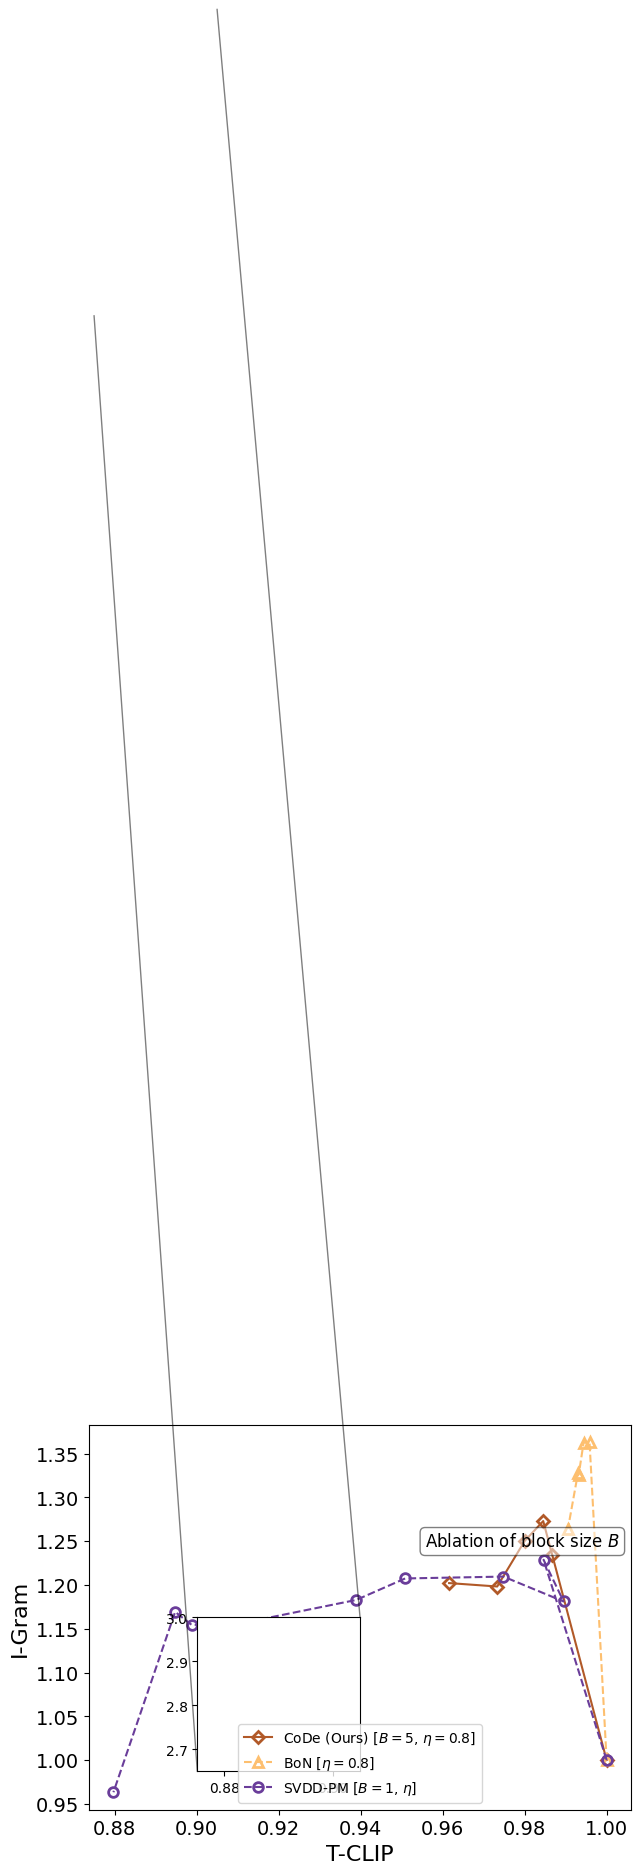

In [168]:
mapping={
    "exp_rew": f"{'(Normalized)' if normalize else ''} Image Alignment",
    "kl": "KL Divergence",
    "fid": "FID",
    "cmmd": "CMMD",
    "ref_fid": "Reference FID",
    "ref_cmmd": "Reference CMMD",
    "win_rate": "Win Rate (Reference Align)",
    "method": "Guidance Method",
    "clipscore": f"T-CLIP",
    "gram": "I-Gram",
    "clipwinrate": "Win Rate (Text Align)"
}

sns.set_style({'legend.frameon':False})

# custom_palette = sns.color_palette("bright")
# c_length = len(custom_palette)

for perf in ['gram']:
    for div in ['clipscore']:

        fig, ax = plt.subplots(figsize=(7,5))

        # g = sns.lineplot(plot_results_selected, x=div, y=perf, hue='method', 
        #                  style='method', linestyle='-',ax=ax, sort=False, markers=markers, markersize=10)

        for i, method in enumerate(plot_results_selected.method.unique().tolist()):
        
            curr_method = plot_results_selected.loc[plot_results['method'] == method]

            if method in ['C-CoDe (Ours) [block 5 r 0.8]']:      
                g = sns.lineplot(x=curr_method[div], y=curr_method[perf], label=label_map_abl[method], c=palette[method], linestyle=linestyles[method], sort=False,
                                marker=markers[method], ax=ax, markersize=6, fillstyle='none', markeredgecolor=None, markeredgewidth=2)
            else:
                g = sns.lineplot(x=curr_method[div], y=curr_method[perf], label=label_map_abl[method], c=palette[method], linestyle=linestyles[method], sort=False,
                                marker=markers[method], ax=ax, markersize=7, fillstyle='none', markeredgecolor=None, markeredgewidth=2)
        

        plt.xlabel(mapping[div], fontsize=16)
        plt.ylabel(mapping[perf], fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)

        # noise ratio
        # x1, x2, y1, y2 = 0.94, 0.99, 1.2, 1.9  # subregion of the original image (smaller box)

        # block
        x1, x2, y1, y2 = 0.875, 0.905, 2.65, 3.0  # subregion of the original image (smaller box)

        axins = ax.inset_axes(
            [0.20, 0.1, .3, .4], # subregion of the original image (bigger box)
            xlim=(x1, x2), ylim=(y1, y2)) #, xticklabels=[], yticklabels=[])
        ax.indicate_inset_zoom(axins, edgecolor="black")

        for i, method in enumerate(plot_results_selected.method.unique().tolist()):
            curr_method = plot_results_selected.loc[plot_results['method'] == method]
            if method in ['C-CoDe (Ours) [block 5 r 0.8]']:      
                g = sns.lineplot(x=curr_method[div], y=curr_method[perf], label=method, c=palette[method], linestyle=linestyles[method], sort=False,
                                marker=markers[method], ax=axins, markersize=8, fillstyle='none', markeredgecolor=None, markeredgewidth=2, legend=False)
            else:
                g = sns.lineplot(x=curr_method[div], y=curr_method[perf], label=method, c=palette[method], linestyle=linestyles[method], sort=False,
                                marker=markers[method], ax=axins, markersize=9, fillstyle='none', markeredgecolor=None, markeredgewidth=2, legend=False)
        
        axins.set_xlabel('')
        axins.set_ylabel('')
        

        textstr = 'Ablation of block size ' + r'$B$'
        # textstr = 'Ablation of noise ratio ' + r'$\eta$'

        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)

        # place a text box in upper left in axes coords

        # Noise
        # ax.text(0.62, 0.66, textstr, transform=ax.transAxes, fontsize=12,
        #         verticalalignment='top', bbox=props)

        # Block
        ax.text(0.62, 0.72, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=props)
        
    
        plt.tight_layout()
        plt.show()
        # plt.savefig(OUTPUTS_DIR.joinpath('new_plots').joinpath(f'{perf}-vs-{div}_{task}_r.png'), dpi=300)
        # plt.close()

        break

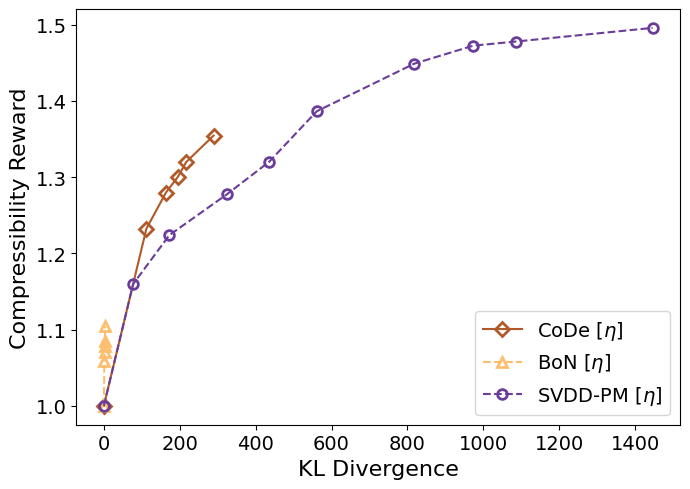

In [21]:
mapping={
    # "exp_rew": f"{'(Normalized)' if normalize else ''} Exp. Reward",
    "exp_rew": f"Compressibility Reward",
    "kl": "KL Divergence",
    "fid": "Base FID",
    "cmmd": "Base CMMD",
    "ref_fid": "Reference FID",
    "ref_cmmd": "Reference CMMD",
    "win_rate": "Win Rate",
    "method": "Guidance Method",
    "clipscore": f"T-CLIP",
    "gram": f"{'(Normalized)' if normalize else ''} I-Gram",
    "clipwinrate": "Win Rate (Text Align)"
}

sns.set_style({'legend.frameon':False})

# custom_palette = sns.color_palette("bright")
# c_length = len(custom_palette)

for perf in ['exp_rew']: #['exp_rew', "win_rate"]: # ['fid'] #, "gram"
    for div in ['kl']: #["fid", 'cmmd', "clipscore"]: # ['ref_fid']

        
        fig, ax = plt.subplots(figsize=(7,5))

        # g = sns.lineplot(plot_results_selected, x=div, y=perf, hue='method', 
        #                  style='method', linestyle='-',ax=ax, sort=False, markers=markers, markersize=10)

        for i, method in enumerate(plot_results_selected.method.unique().tolist()):
        
            curr_method = plot_results_selected.loc[plot_results_selected['method'] == method]
            if task == 'compress' and (div =='gram' or perf == 'gram'):
                curr_method = curr_method[curr_method.param != '']
            try:
                if method == 'SDEdit' or method == 'C-UG': 
                    divs = np.roll(np.array(curr_method[div]), -1)
                    perfs = np.roll(np.array(curr_method[perf]), -1)
                else:
                    divs = np.array(curr_method[div])
                    perfs = np.array(curr_method[perf])

                g = sns.lineplot(x=divs, y=perfs, c=palette[method], linestyle=linestyles[method], sort=False,
                                marker=markers[method], ax=ax, markersize=7, fillstyle='none', markeredgecolor=None, markeredgewidth=2, label=label_map[method])
            except Exception as e:
                print(method)
                print(e)
                break

        plt.xlabel(mapping[div], fontsize=16)
        plt.ylabel(mapping[perf], fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)

        # handles, l_labels = ax.get_legend_handles_labels()
        plt.legend(fontsize=14, loc=3) if div == 'clipscore' else plt.legend(fontsize=14, loc=4)

        plt.tight_layout()
        # plt.show()
        plt.savefig(OUTPUTS_DIR.joinpath('plots_revised_add').joinpath(f'{perf}-vs-{div}_{task}.png'), dpi=300)
        # plt.close()

        # break

In [95]:
plot_results

,method,exp_rew,win_rate,fid,cmmd,clipscore,clipwinrate,gram,param,kl
0,SDv1.5,NaN,0.500000,80.100000,0.040000,0.766375,0.500000,0.096717,,0.000000
1,C-CoDe (Ours) [block 5 r 0.8],NaN,0.500000,80.100000,0.040000,0.766375,0.500000,0.096717,,0.000000
2,C-CoDe (Ours) [block 5 r 0.8],NaN,0.912500,182.755588,1.413667,0.756217,0.350000,0.119364,10_b5_r8,112.206807
3,C-CoDe (Ours) [block 5 r 0.8],NaN,0.925000,201.471367,1.573000,0.754525,0.386111,0.123119,20_b5_r8,163.658582
4,C-CoDe (Ours) [block 5 r 0.8],NaN,0.929167,193.627110,1.623417,0.751067,0.341667,0.120929,30_b5_r8,194.762457
5,C-CoDe (Ours) [block 5 r 0.8],NaN,0.941667,215.280914,1.777417,0.745925,0.391667,0.115891,40_b5_r8,217.110356
6,C-CoDe (Ours) [block 5 r 0.8],NaN,0.950000,249.923359,1.964083,0.736942,0.333333,0.116269,100_b5_r8,289.213615
7,C-BoN [r 0.8],NaN,0.500000,80.100000,0.040000,0.766375,0.500000,0.096717,,0.000000
8,C-BoN [r 0.8],NaN,0.679167,196.014788,1.334750,0.763183,0.450000,0.131831,10_r8,1.402585
9,C-BoN [r 0.8],NaN,0.704167,195.034031,1.307917,0.762067,0.425000,0.131768,20_r8,2.045732


In [54]:
plot_results_selected.iloc[0].param

''

In [149]:
import plotly.express as px

div = 'win_rate' # 'exp_rew', 'win_rate'
perf = 'fid' # 'fid', 'mmd', 'kl'

custom_data = ['exp_rew', 'cmmd', 'fid', 'win_rate', 'clipscore', 'clipwinrate', 'ref_fid', 'ref_cmmd', 'gram', 'param']

g = px.line(plot_results_selected, x=perf, y=div, color='method', symbol='method', markers=['o', '^'],
            labels={
                     "exp_rew": f"{'(Normalized)' if normalize else ''} Image Alignment",
                     "kl": "KL Divergence",
                     "fid": "Source FID",
                     "cmmd": "Source CMMD",
                     "ref_fid": "Reference FID",
                     "ref_cmmd": "Reference CMMD",
                     "win_rate": "Win Rate (Reference Align)",
                     "method": "Guidance Method",
                     "clipscore": "T-CLIP",
                     "clipwinrate": "Win Rate (Text Align)",
                     "gram": "I-Gram"
                 },
            custom_data=custom_data,
            title=task
            )

g.update_traces(
    hovertemplate="<br>".join([
        "Expected Rewards: %{customdata[0]}",
        "FID: %{customdata[2]}",
        "CMMD: %{customdata[1]}",
        "Win Rate (Reference Align): %{customdata[3]}",
        "Clipscore: %{customdata[4]}",
        "Win Rate (Text Align): %{customdata[5]}",
        "Target FID: %{customdata[6]}",
        "Target CMMD: %{customdata[7]}",
        "Gram: %{customdata[8]}",
        "Params: %{customdata[9]}",
    ])
)

g.show()

In [ ]:
import plotly.express as px

div = 'gram' # 'exp_rew', 'win_rate'
perf = 'clipscore' # 'fid', 'mmd', 'kl'

custom_data = ['exp_rew', 'cmmd', 'fid', 'win_rate', 'clipscore', 'clipwinrate', 'ref_fid', 'ref_cmmd', 'gram', 'param']

g = px.line(plot_results_selected, x=perf, y=div, color='method', symbol='method', markers=['o', '^'],
            labels={
                     "exp_rew": f"{'(Normalized)' if normalize else ''} Image Alignment",
                     "kl": "KL Divergence",
                     "fid": "Source FID",
                     "cmmd": "Source CMMD",
                     "ref_fid": "Reference FID",
                     "ref_cmmd": "Reference CMMD",
                     "win_rate": "Win Rate (Reference Align)",
                     "method": "Guidance Method",
                     "clipscore": "T-CLIP",
                     "clipwinrate": "Win Rate (Text Align)",
                     "gram": "I-Gram"
                 },
            custom_data=custom_data,
            title=task
            )

g.update_traces(
    hovertemplate="<br>".join([
        "Expected Rewards: %{customdata[0]}",
        "FID: %{customdata[2]}",
        "CMMD: %{customdata[1]}",
        "Win Rate (Reference Align): %{customdata[3]}",
        "Clipscore: %{customdata[4]}",
        "Win Rate (Text Align): %{customdata[5]}",
        "Target FID: %{customdata[6]}",
        "Target CMMD: %{customdata[7]}",
        "Gram: %{customdata[8]}",
        "Params: %{customdata[9]}",
    ])
)

g.show()

In [5]:
# _METHODS_STYLE = {
#     'CoDe (Ours)' : 'code',
#     'C-CoDe (Ours)' : 'c_code30_b5_r5_styletransfer',
#     'BoN' : 'bon30_facedetector',
#     'DPS (Chung 2023)' : 'grad13_styletransfer',
#     'Universal Guidance (Bansal, 2024)': 'test'
# }

In [5]:
from PIL import Image

In [10]:
_METHODS_FACE = {
    'SDv1.5': 'uncond_facedetector',
    'BoN' : 'bon30_facedetector',
    'DPS (Chung 2023)' : 'grad500_facedetector',
    'Universal Guidance (Bansal, 2024)': 'test_face_20000',
    'CoDe (Ours)' : 'code30_b5_facedetector',
    'C-CoDe (Ours)' : 'c_code30_b5_r8_facedetector',
}

ug_face_map = {
    'og_img_4' : 'og_img_0',
    'og_img_6' : 'og_img_1',
    'og_img_8' : 'og_img_2',
}

base_path = Path('../BoN/outputs/cherry_picking')

save_path = Path('../BoN/outputs/plots/facedetector')

target_dirs = [x for x in save_path.iterdir() if Path.is_dir(x)]
for target_dir in target_dirs:

    prompt_dirs = [x for x in target_dir.joinpath('images').iterdir() if Path.is_dir(x)]
    for prompt_dir in prompt_dirs:

        fig, ax = plt.subplots(5, 7, figsize=(20,15))

        target_path = Path('../BoN/assets/face_data/celeb')
        target = Image.open(target_path.joinpath(f'{target_dir.stem}.png'))
        ax[0][0].set_title('target')
        ax[0][0].imshow(target)
        ax[0][0].axis('off')
        for i in range(4):
            ax[i+1][0].axis('off')

        for j, method in enumerate(_METHODS_FACE.keys()):

            curr_target = ug_face_map[target_dir.stem] if 'Universal' in method else target_dir.stem
            
            img_path = base_path.joinpath(_METHODS_FACE[method]).joinpath(curr_target).joinpath('images').joinpath(prompt_dir.stem)
            if not Path.exists(img_path):
                for i in range(5):
                    ax[i][j+1].axis('off')
                    if i == 0:
                        ax[i][j+1].set_title(method[:4])

                continue

            imgs = [x for x in img_path.iterdir() if Path.is_file(x)]
            
            for i in range(5):
                if i < len(imgs):
                    ax[i][j+1].imshow(Image.open(imgs[i]))
                ax[i][j+1].axis('off')

                if i == 0:
                    ax[i][j+1].set_title(method)

        fig.suptitle(f'{target_dir.stem} : {prompt_dir.stem}')
        plt.tight_layout()
        # plt.show()

        plt_save = save_path.joinpath(target_dir.stem).joinpath('images').joinpath(prompt_dir.stem)
        # plt.show()
        # print(plt_save)
        plt.savefig(plt_save.joinpath('res.png'), dpi=300)
        plt.close()

    #     break
    # break

In [1]:
from PIL import Image

In [2]:
img = Image.open('../BoN/assets/face_data/celeb/og_img_9.jpg')
img.save('../BoN/assets/face_data/celeb/og_img_9.png')